# Machine Learning Project 2022: Plankton

### Authors:
- Bram Fresen
- Bram Huis
- Max Burger
- Moos Middelkoop

For the Machine Learning Project to finish off the minor Artificial Intelligence, we chose to tackle the plankton problem, originally uploaded as the United States national data science bowl in december 2014. For this problem, the goal is to classify microscopic images of particles in water as one of 121 different classes of plankton. The dataset is 30.000 images large, with varying sizes. The dataset is also imbalanced.

In order to solve this problem we will make use of a Convolutional Neural Network using the tensorflow library.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Import libraries

Firstly, we will import the needed libraries, and check if we are running on a GPU.

In [3]:
import tensorflow as tf 
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns

from tensorflow import math as tfmath
from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight

print(tf.config.list_physical_devices('GPU'))

[]


## Loading the training data and training labels

We use the cv2 library to load the training images (which are .jpg files), and turn them into arrays. This piece of code was found online:

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

### Training data

Training data is sorted into folders by class, this next piece of code reads in the training data, puts it in an array, and constructs an array for the classes by using the names of the folders. At the end, this array for the labels is turned into a one-hot matrix, so that tensorflow can work with it.

We also delete the unnecessary channels here already, all input images consist of 3 channels with exactly the same values, so we drop two of them in order to remove redundant data.

In [4]:
def read_data(folder):
    # Create empty lists for the not resized training data, the labels (not one hot encoded yet) and the class sizes
    train_data = []
    train_labels = []
    class_size_list = []
    categories_list =[]
    offset = 0

    # Loop through the index (for the one hot matrix) and the categories
    for number, categories in enumerate(os.listdir(folder)):
        class_size = 0
        categories_list.append(categories)
        print(number)

        # If we come across a hidden folder (starting with ".") on mac os, we ignore it
        if categories[0] == ".":
            offset += 1
            continue

        # Loop through the images , add 1 to the class size, read the images in in and add them to a list, 
        # also add the index 'number' to a list for the one hot matrix
        for image in os.listdir(f'{folder}/{categories}'):
            class_size += 1
            train_labels.append(number - offset)
            img = cv2.imread(os.path.join(f'{folder}/{categories}', image))
            train_data.append(img[:, :, 0])
      
        # Append the size of the class to the class size list, in order to check the class sizes later, this way we
        # can ananlyze the degree of class imbalance
        class_size_list.append(class_size)

    # Create a one hot matrix from the train labels
    train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=121)
  
    return train_data, train_labels_one_hot, class_size_list, categories_list

train_data, train_labels, class_size_list, categories_list = read_data('data/train')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


# Resize input images

Because all images are differnt sizes, it is necessary to resize all input data to the same size, in order to make tensorflow be able to work with the data. The first cell below analyzes the sizes of the data, and the second cell actually resizes, based on this analysis. An essential element is explicitly adding a third dimension with a value of 1 to the images, otherwise tensorflow can't work with the data. Lastly, the data is converted into numpy arrays, so tensorflow will be able to work with them

Average dimensions: 66.66182093881856, 73.50728507383967
Lowest first dimension image (21, 71)
Lowest second dimension image (31, 49)


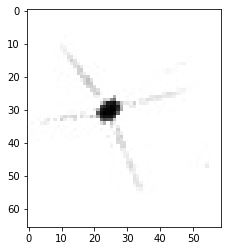

In [5]:
# Start with an infinitely large number
value_1 = math.inf
value_2 = math.inf
sum_1 = 0
sum_2 = 0
count = 0

# This checks for the lowest image size in the first and second dimension
for image in train_data:
    count+=1
    sum_1 += image.shape[0]
    sum_2 += image.shape[1]
    if image.shape[0] < value_1:
        
        value_1 = image.shape[0]
        hold_1 = image.shape
    if image.shape[1] < value_2:
        
        value_2 = image.shape[0]
        hold_2 = image.shape
        
sum_11 = sum_1 / count
sum_22 = sum_2 / count

print(f'Average dimensions: {sum_11}, {sum_22}')

plt.imshow(train_data[0], cmap = 'gray')

print(f'Lowest first dimension image {hold_1}')
print(f'Lowest second dimension image {hold_2}')

## Resizing Function

In the cell below, we define a function that resizes a given image to a dimension given the optimal manner of up- or downscaling. 

(27, 27, 1)


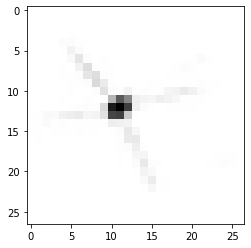

In [39]:
def resizer(image, target_dimension):
    '''
    Takes an image and a desired dimension (tuple), and converts the image given the best interpolation method
    '''

    if len(image[0]) * len(image[1]) > target_dimension[0] * target_dimension[1]:
        rescaled_image = np.expand_dims(cv2.resize(image, dsize = target_dimension, interpolation = cv2.INTER_AREA), axis = 2) 
    else:
        rescaled_image = np.expand_dims(cv2.resize(image, dsize = target_dimension, interpolation = cv2.INTER_CUBIC), axis = 2)        
    return rescaled_image    
    
# Create an empty list for the training data
train_data_resized = []
target_dim = (27, 27)

# Loop through the images in the training data and resize them to desired dimension
for image in train_data:
    train_data_resized.append(resizer(image, target_dim))

# Test if the image is resized and show the image
print(train_data_resized[0].shape)
plt.imshow(train_data_resized[0], cmap = 'gray')

#Split the data into 70% training and 30% validation
im_train, im_val, lab_train, lab_val = train_test_split(train_data_resized, train_labels, train_size=0.7, random_state=1265599650)

In [35]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(im_train)
label_train = np.array(lab_train)
image_val = np.array(im_val)
label_val = np.array(lab_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

(21235, 27, 27, 1)
(21235, 121)
(9101, 27, 27, 1)
(9101, 121)


## Convolutional network

We use the function 'train_and_evaluate' which, obviously, trains our model and then evaluates the trained model on the validation data. This function was reused from the CIFAR-assignment from module 6 of ML2.

Y_ints line: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [36]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    # used for k-fold
    y_ints = [y.argmax() for y in label_train]
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_ints), y = y_ints)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    return model.evaluate(val_gen.flow(val_x, val_y))[1]

## The actual model

We start with a very simple convolutional neural network, with 2 convolutional layers, both with pooling afterwards, and one dense layer. kernelsize, amount of filters, amount of nodes are specified in the code cell. This first version of the model gives us a validation accuracy of approximately 64%

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 664 steps, validate for 285 steps
Epoch 1/80
664/664 [==============================] - 19s 28ms/step - loss: 4.3259 - accuracy: 0.0878 - val_loss: 4.5156 - val_accuracy: 0.0683
Epoch 2/80
664/664 [==============================] - 17s 26ms/step - loss: 3.9949 - accuracy: 0.1235 - val_loss: 5.1251 - val_accuracy: 0.0674
Epoch 3/80
664/664 [==============================] - 18s 27ms/step - loss: 3.5838 - accuracy: 0.1787 - val_loss: 5.1942 - val_accuracy: 0.0739
Epoch 4/80
664/664 [==============================] - 18s 27ms/step - loss: 3.1713 - accuracy: 0.2405 - val_loss: 3.6506 - val_accuracy: 0.1557
Epoch 5/80
664/664 [==============================] - 18s 27ms/step - loss: 2.8644 - accuracy: 0.2901 - val_loss: 3.0022 - val_accuracy: 0.2635
Epoch 6/80
664/664 [==============================] - 19s 28ms/step - loss: 2.6569 - accuracy: 0.3232 - val_loss: 2.8984 - val_accuracy: 0.2866
Epoch 7/80
664/664 [==============================] - 18s 27ms/step - loss: 2.5064 - accurac

664/664 [==============================] - 19s 28ms/step - loss: 1.1421 - accuracy: 0.6434 - val_loss: 1.4500 - val_accuracy: 0.6039
Epoch 58/80
664/664 [==============================] - 20s 30ms/step - loss: 1.1227 - accuracy: 0.6464 - val_loss: 1.3920 - val_accuracy: 0.6196
Epoch 59/80
664/664 [==============================] - 19s 29ms/step - loss: 1.1268 - accuracy: 0.6438 - val_loss: 1.4359 - val_accuracy: 0.6080
Epoch 60/80
664/664 [==============================] - 18s 28ms/step - loss: 1.1150 - accuracy: 0.6513 - val_loss: 1.4072 - val_accuracy: 0.6160
Epoch 61/80
664/664 [==============================] - 19s 29ms/step - loss: 1.0987 - accuracy: 0.6536 - val_loss: 1.3609 - val_accuracy: 0.6281
Epoch 62/80
664/664 [==============================] - 19s 28ms/step - loss: 1.0810 - accuracy: 0.6555 - val_loss: 1.4038 - val_accuracy: 0.6200
Epoch 63/80
664/664 [==============================] - 18s 28ms/step - loss: 1.0835 - accuracy: 0.6595 - val_loss: 1.3572 - val_accuracy: 0.62

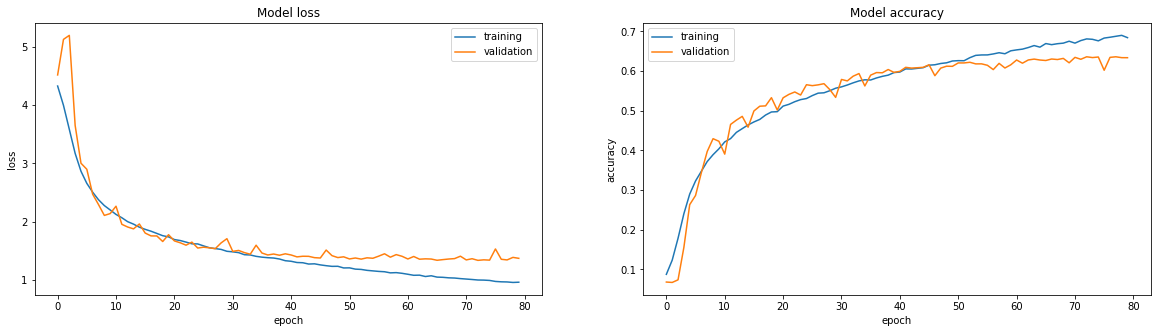

  ...
    to  
  ['...']


  ...
    to  
  ['...']


285/285 [==============================] - 2s 8ms/step - loss: 1.3716 - accuracy: 0.6339
Validation Accuracy: 0.6338863968849182
  ...
    to  
  ['...']


  ...
    to  
  ['...']


285/285 [==============================] - 2s 8ms/step - loss: 1.3703 - accuracy: 0.6339


0.6338864

In [37]:
first_layer_filters = 32
second_layer_filters = 64
third_layers_filters = 128

kernelsize = (3,3)
inputshape = (27,27, 1)
first_hidden_layer_nodes = 1024
second_hidden_layer_nodes = 512
output_nodes = 121
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
# optimizer = 'adam'

model_1 = models.Sequential()

model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((3, 3)))
model_1.add(layers.Dropout(0.2))


model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = 'relu', padding = 'same'))
model_1.add(layers.MaxPooling2D((3, 3)))
model_1.add(layers.BatchNormalization())

model_1.add(layers.Flatten())
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(first_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(second_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dropout(0.35))
model_1.add(layers.Dense(output_nodes, activation = 'softmax'))

train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 80)

In [10]:
model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

## Different resizing 

Text(0.5, 1.0, 'Lanczos interpolation:')

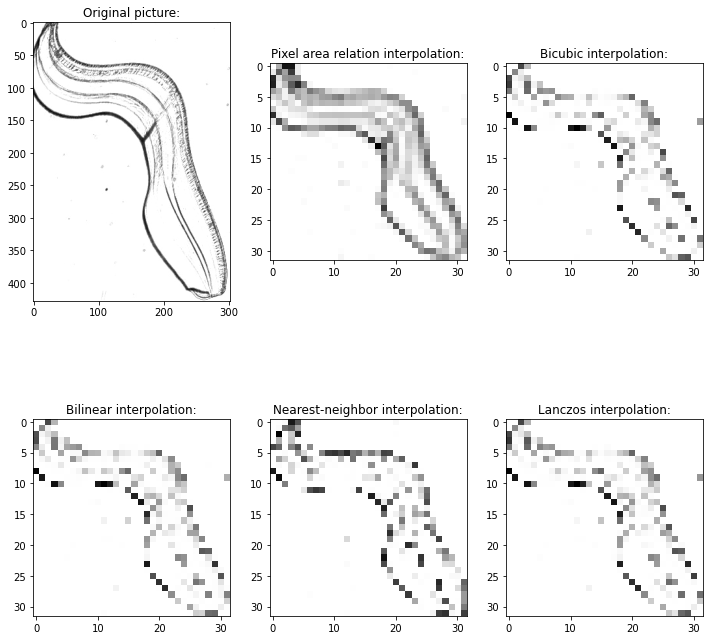

In [11]:
# Filter out the largest example (and possibily the second-largest) to illustrate resizing
storage_1 = 0 
storage_2 = 0
store_img1 = None
store_img2 = None
for image in train_data:
    store = image.shape[0]
    if store > storage_1 and store > storage_2:
        store_img1 = image
        storage_1 = image.shape[0]
    if store > storage_2 and store != storage_1:
        store_img2 = image
        storage_2 = image.shape[0]
        

# Plot the different manners of interpolation for comparison
f, axarr = plt.subplots(2,3, figsize=(12, 12))
axarr[0,0].imshow(store_img1, cmap = 'gray')
axarr[0,0].set_title('Original picture:')
axarr[1,0].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_LINEAR), cmap = 'gray')
axarr[1,0].set_title('Bilinear interpolation:')
axarr[0,1].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_AREA), cmap = 'gray')
axarr[0,1].set_title('Pixel area relation interpolation:')
axarr[1,1].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_NEAREST), cmap = 'gray')
axarr[1,1].set_title('Nearest-neighbor interpolation:')
axarr[0,2].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_CUBIC), cmap = 'gray')
axarr[0,2].set_title('Bicubic interpolation:')
axarr[1,2].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_LANCZOS4), cmap = 'gray')
axarr[1,2].set_title('Lanczos interpolation:')

#plt.savefig('resizingmethods.png')

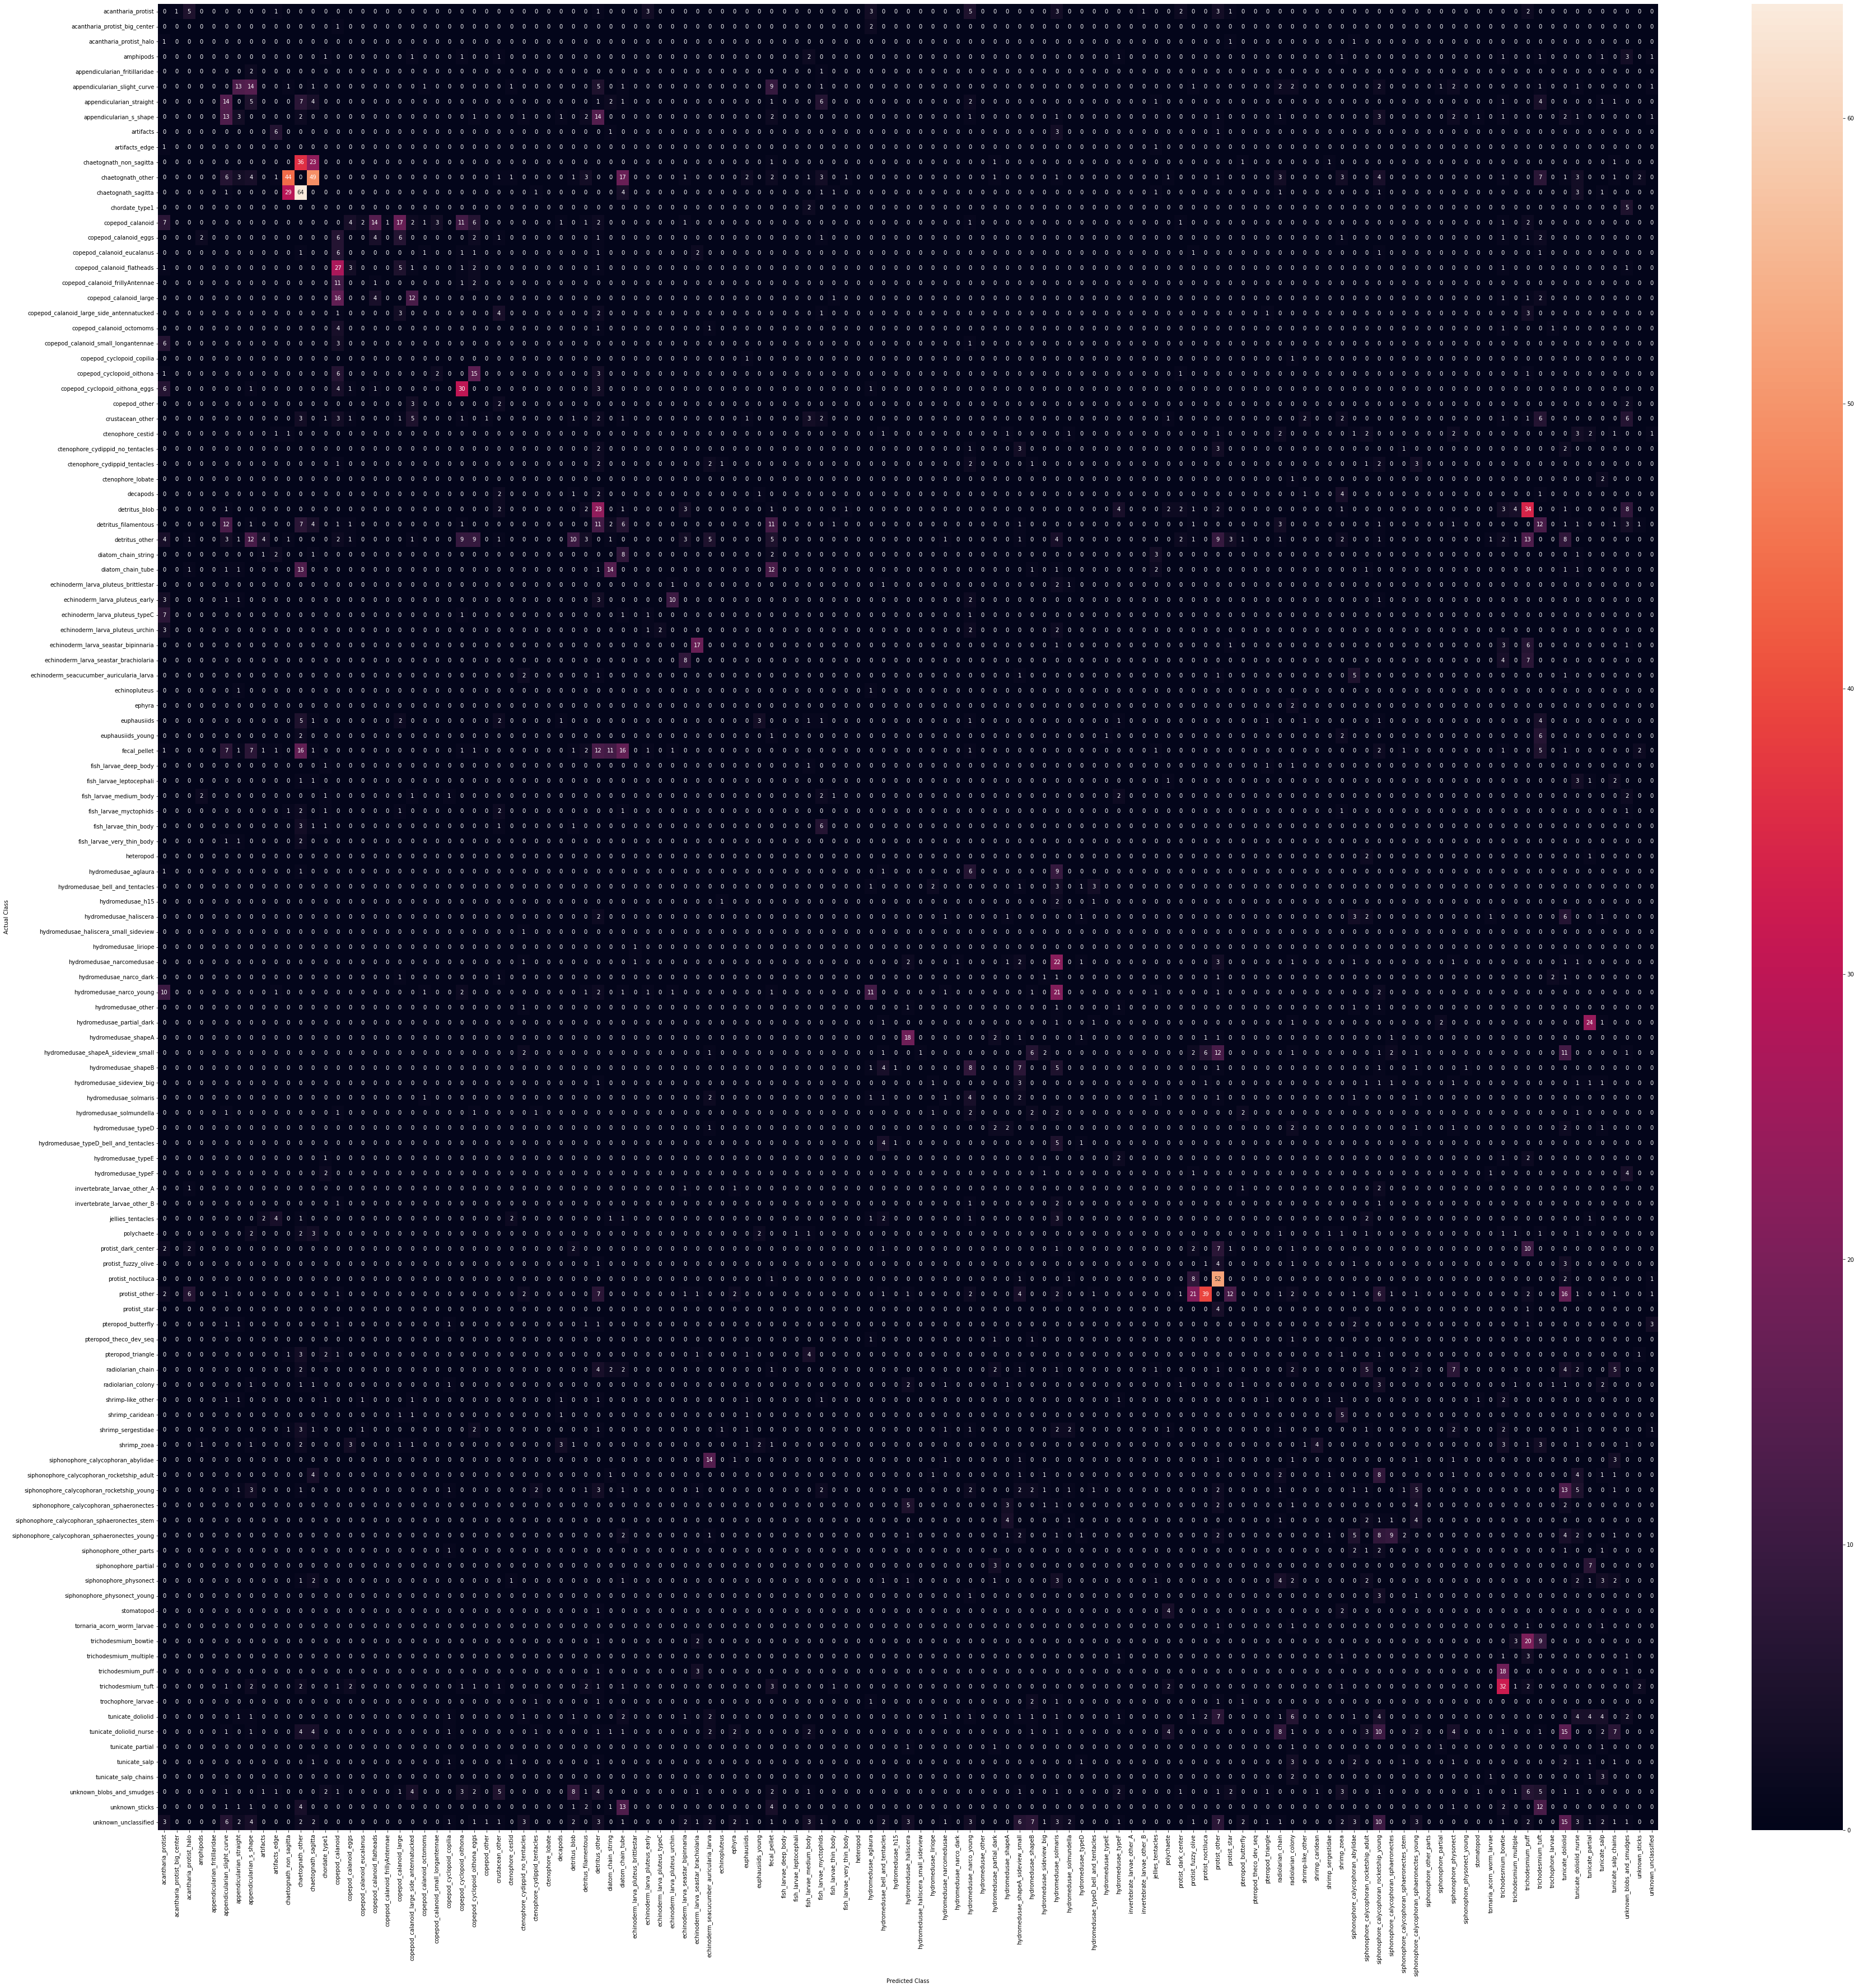

C:\Users\maxbu\anaconda3\envs\progLab\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


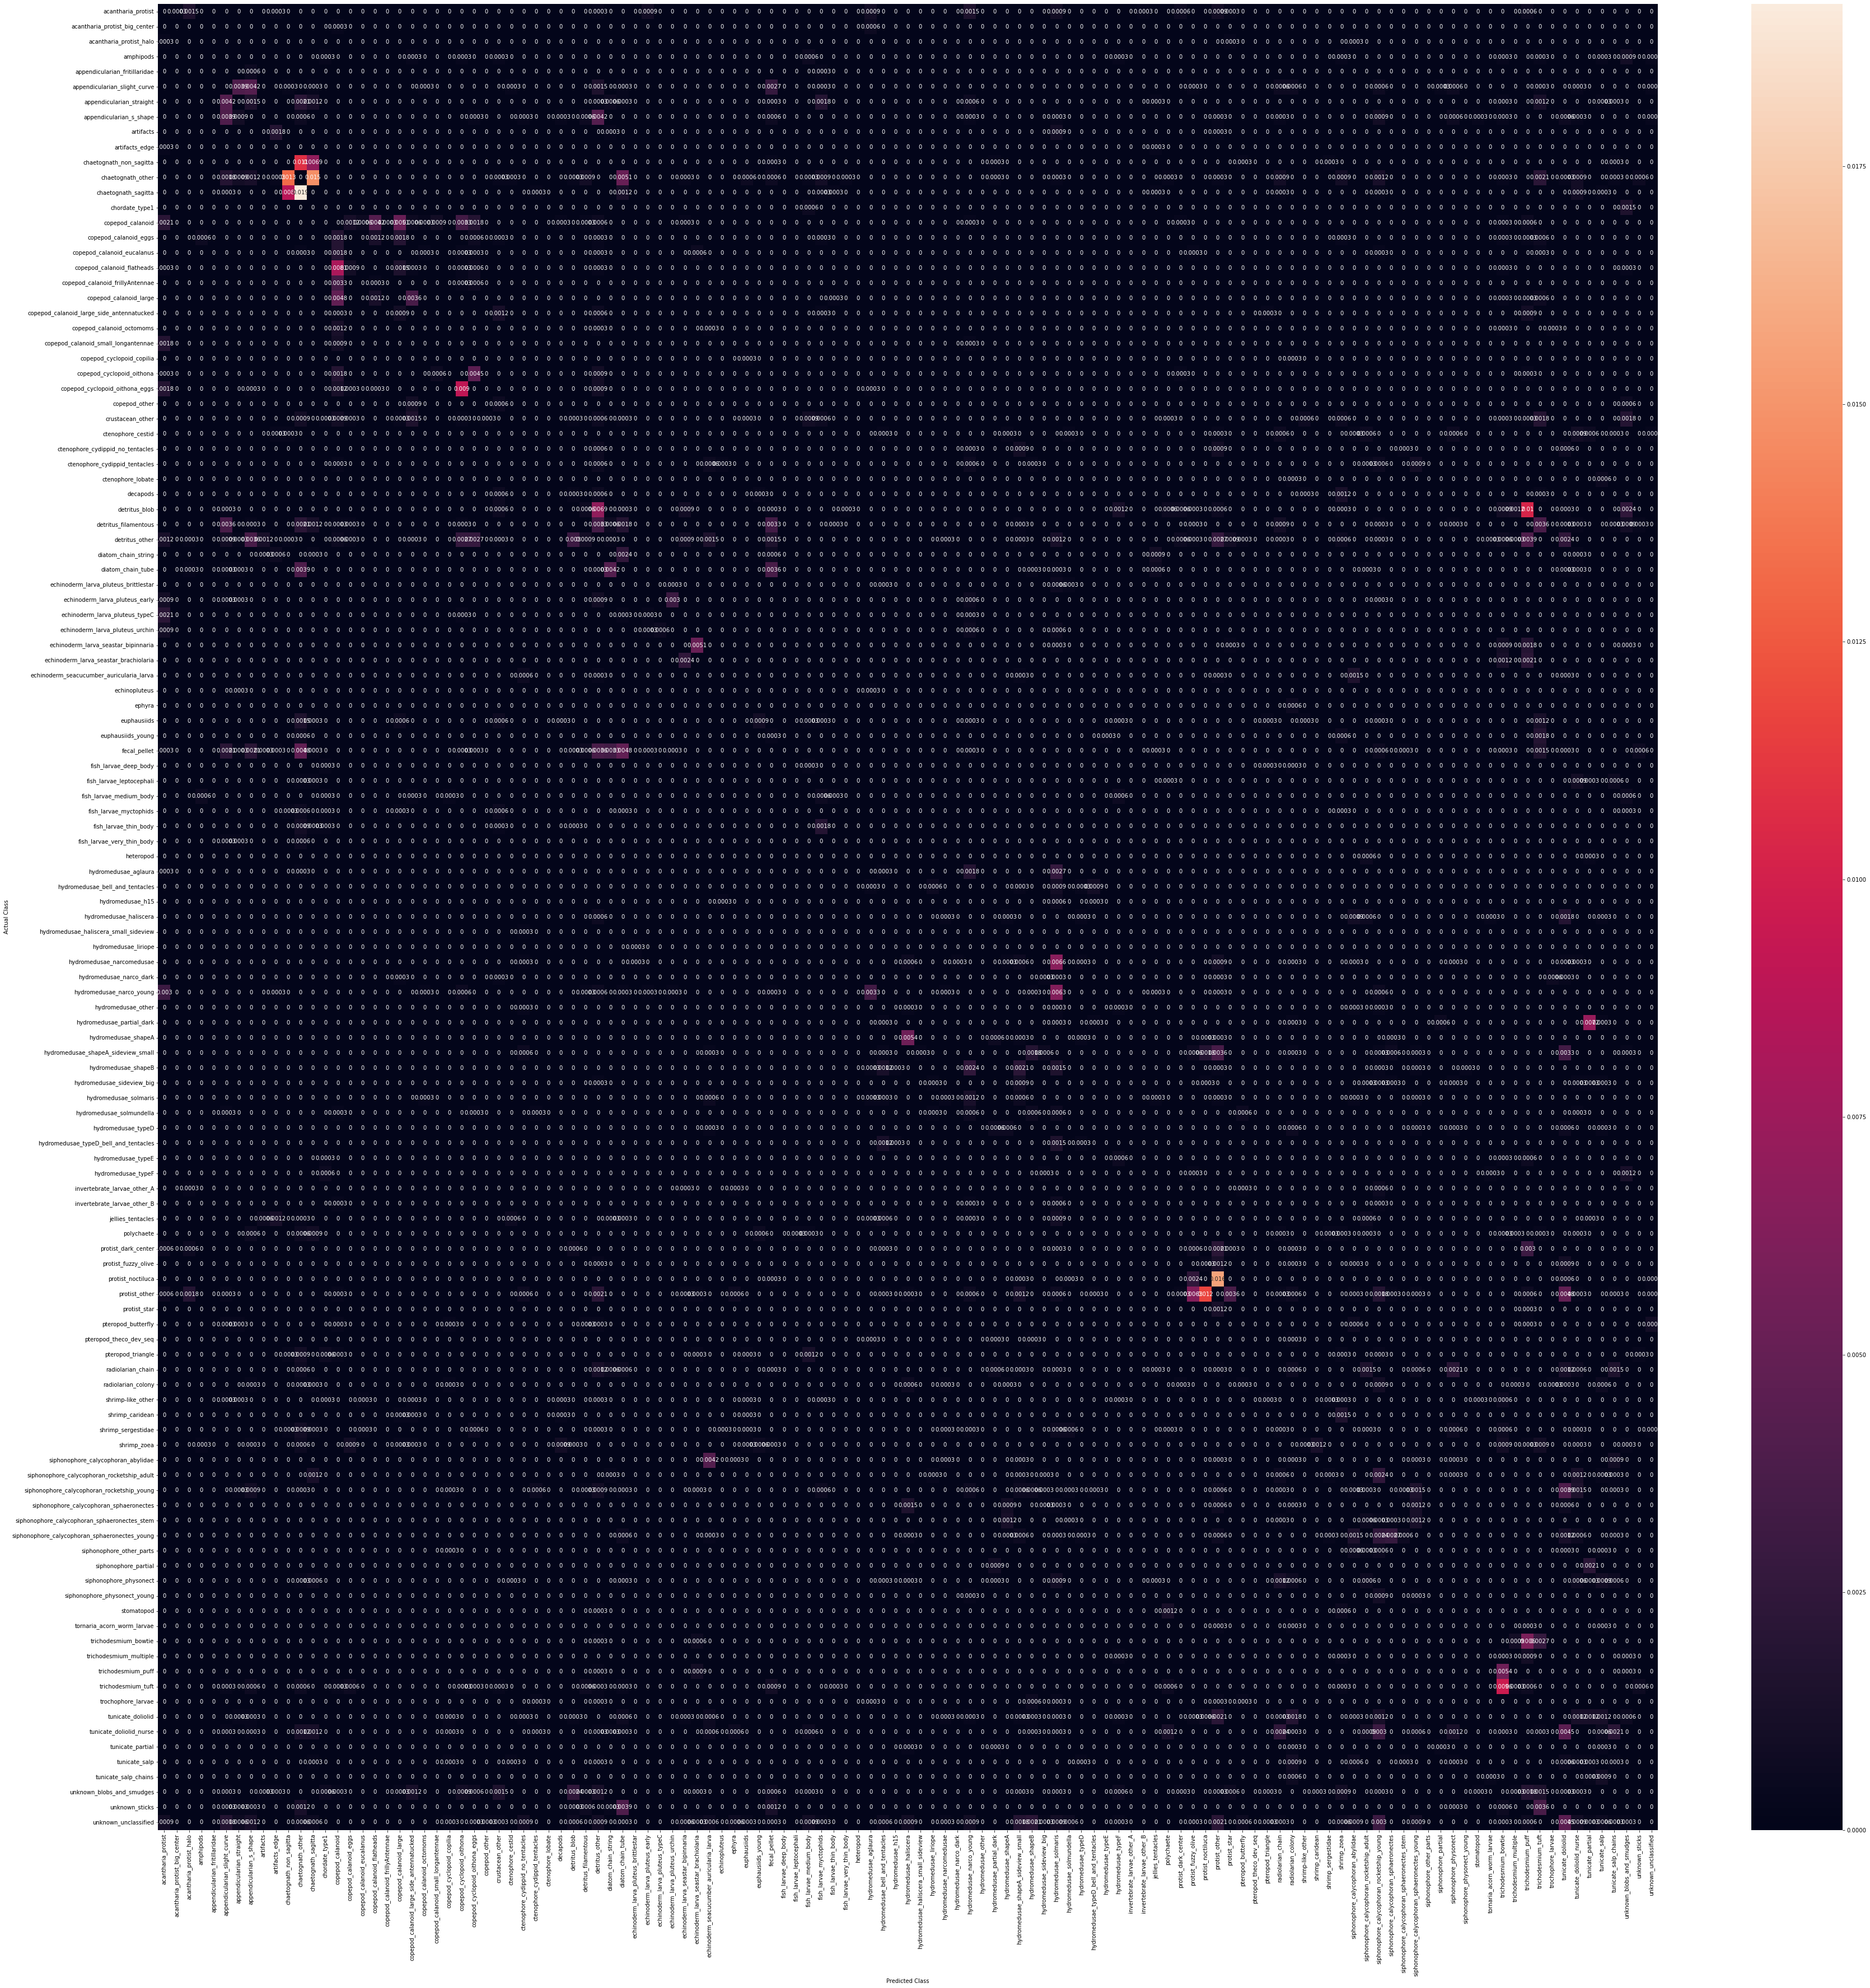

In [38]:
# First compute the predictions based on the trained model
y_pred = tf.keras.utils.to_categorical(model_1.predict_classes(image_val))


# Convert both actual and predict to utilize in conf matrix 
y_true = tf.argmax(label_val, axis=1)
y_pred = tf.argmax(y_pred, axis=1)

# Compute matrix
conf_matrix = tfmath.confusion_matrix(y_true, y_pred)

# Remove the diagonal for clearer image
cnf_mtrx = np.array(conf_matrix)
np.fill_diagonal(cnf_mtrx, 0)

# Compute heatmap for abosulte numbers

plt.figure(figsize=(60,60))
ax = sns.heatmap(cnf_mtrx, annot=True, fmt="d", xticklabels=categories_list, yticklabels=categories_list)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

# Compute the relative (%) cf matrix and corresponding heatmap

cnf_mtrx = np.nan_to_num((cnf_mtrx / cnf_mtrx.astype(np.float).sum()), copy=True, nan=0.0, posinf=None, neginf=None)
plt.figure(figsize=(60,60))
ax = sns.heatmap(cnf_mtrx, annot=True, xticklabels=categories_list, yticklabels=categories_list)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')

plt.show()

## Stratified K-folds

In the cell below, we can train the model in K stratified folds, meaning we can test the model over different test and train splits that take the distribution of classes into account when making said splits.

TRAIN: [  178   179   180 ... 30333 30334 30335] TEST: [    0     1     2 ... 29993 29994 29995]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 759 steps, validate for 190 steps
Epoch 1/80
759/759 [==============================] - 20s 26ms/step - loss: 4.2352 - accuracy: 0.0996 - val_loss: 4.4926 - val_accuracy: 0.0717
Epoch 2/80
759/759 [==============================] - 19s 25ms/step - loss: 3.5859 - accuracy: 0.1865 - val_loss: 3.6780 - val_accuracy: 0.1866
Epoch 3/80
759/759 [==============================] - 19s 25ms/step - loss: 3.1031 - accuracy: 0.2565 - val_loss: 3.0118 - val_accuracy: 0.2816
Epoch 4/80
759/759 [==============================] - 20s 26ms/step - loss: 2.8158 - accuracy: 0.2978 - val_loss: 2.8742 - val_accuracy: 0.2966
Epoch 5/80
759/759 [==============================] - 20s 26ms/step - loss: 2.6135 - accuracy: 0.3267 - val_loss: 2.7650 - val_accuracy: 0.3194
Epoch 6/80
759/759 [==============================] - 20s 26ms/step - loss: 2.4647 - accu

759/759 [==============================] - 22s 29ms/step - loss: 1.1420 - accuracy: 0.6431 - val_loss: 1.3086 - val_accuracy: 0.6305
Epoch 56/80
759/759 [==============================] - 22s 29ms/step - loss: 1.1276 - accuracy: 0.6527 - val_loss: 1.2736 - val_accuracy: 0.6381
Epoch 57/80
759/759 [==============================] - 22s 29ms/step - loss: 1.1249 - accuracy: 0.6495 - val_loss: 1.2766 - val_accuracy: 0.6388
Epoch 58/80
759/759 [==============================] - 22s 29ms/step - loss: 1.1084 - accuracy: 0.6503 - val_loss: 1.2939 - val_accuracy: 0.6340
Epoch 59/80
759/759 [==============================] - 22s 28ms/step - loss: 1.1077 - accuracy: 0.6502 - val_loss: 1.2869 - val_accuracy: 0.6397
Epoch 60/80
759/759 [==============================] - 22s 29ms/step - loss: 1.1039 - accuracy: 0.6506 - val_loss: 1.3095 - val_accuracy: 0.6355
Epoch 61/80
759/759 [==============================] - 22s 29ms/step - loss: 1.0918 - accuracy: 0.6539 - val_loss: 1.2723 - val_accuracy: 0.64

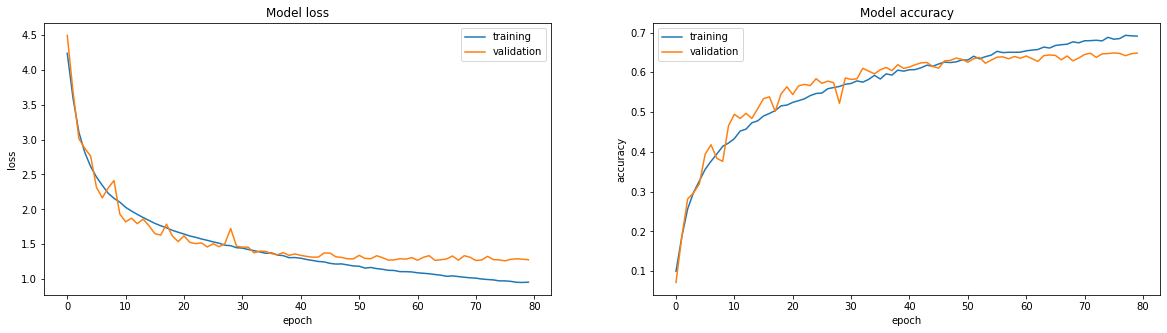

  ...
    to  
  ['...']
190/190 [==============================] - 1s 7ms/step - loss: 1.2811 - accuracy: 0.6482
Validation Accuracy: 0.6481542587280273
  ...
    to  
  ['...']
190/190 [==============================] - 1s 7ms/step - loss: 1.2782 - accuracy: 0.6482
TRAIN: [    0     1     2 ... 30333 30334 30335] TEST: [  178   179   180 ... 30078 30079 30080]
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 759 steps, validate for 190 steps
Epoch 1/80
759/759 [==============================] - 21s 28ms/step - loss: 4.3250 - accuracy: 0.0869 - val_loss: 4.7433 - val_accuracy: 0.0752
Epoch 2/80
759/759 [==============================] - 20s 26ms/step - loss: 4.0182 - accuracy: 0.1160 - val_loss: 7.3004 - val_accuracy: 0.0115
Epoch 3/80
759/759 [==============================] - 21s 28ms/step - loss: 3.7785 - accuracy: 0.1402 - val_loss: 8.3680 - val_accuracy: 0.0122
Epoch 4/80
759/759 [==============================] - 21s 27ms/step - loss: 3.5159 - accuracy: 0.1733 - val_l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\maxbu\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\maxbu\AppData\Local\Temp/ipykernel_15072/3724346625.py", line 58, in <module>
    val_accuracy = train_and_evaluate(model_1, X_train, y_train, X_test, y_test, epochs = 80)
  File "C:\Users\maxbu\AppData\Local\Temp/ipykernel_15072/1477403694.py", line 16, in train_and_evaluate
    validation_data=val_gen.flow(val_x, val_y))
  File "C:\Users\maxbu\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\maxbu\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\maxbu\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.

In [ ]:
# Convert data to array before split to use in stratified kfolds
all_image = np.array(train_data_resized)
all_labels = np.array(train_labels)

# Convert one hot matrix back to label vector
y_ints_all = [y.argmax() for y in all_labels]
y_ints_all = np.array(y_ints_all)

n_splits = 5

# Define stratified kfold and number of splits
skf = StratifiedKFold(n_splits= n_splits)
skf.get_n_splits(all_image, all_labels)

StratifiedKFold(n_splits= n_splits, random_state= None, shuffle= False)

val_accuracy_list = []

# Iterate over the splits
for train_index, test_index in skf.split(all_image, y_ints_all):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = all_image[train_index], all_image[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    
    first_layer_filters = 32
    second_layer_filters = 64
    third_layers_filters = 128

    kernelsize = (3,3)
    inputshape = (27,27, 1)
    first_hidden_layer_nodes = 1024
    second_hidden_layer_nodes = 512
    output_nodes = 121
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    # optimizer = 'adam'

    model_1 = models.Sequential()

    model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
    model_1.add(layers.MaxPooling2D((3, 3)))
    model_1.add(layers.Dropout(0.2))


    model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = 'relu', padding = 'same'))
    model_1.add(layers.MaxPooling2D((3, 3)))
    model_1.add(layers.BatchNormalization())

    model_1.add(layers.Flatten())
    model_1.add(layers.Dropout(0.35))
    model_1.add(layers.Dense(first_hidden_layer_nodes, activation = 'relu'))
    model_1.add(layers.Dropout(0.35))
    model_1.add(layers.Dense(second_hidden_layer_nodes, activation = 'relu'))
    model_1.add(layers.Dropout(0.35))
    model_1.add(layers.Dense(output_nodes, activation = 'softmax'))
    
    # Call train and evaluate for every split
    val_accuracy = train_and_evaluate(model_1, X_train, y_train, X_test, y_test, epochs = 80)
    val_accuracy_list.append(val_accuracy)
print("------------------------------------------------------------------")
print(f"The mean accuracy of {n_splits} folds is {np.mean(val_accuracy_list)}")